**First here we are setting up the density, cumulative, inv.cum, and random draw functions for the Laplace distribution: 

In [7]:
##
##  laplaceMechanism.r
##
##  demonstrate Laplace mechanism on release of means and regression slopes
##
##  jH 2019.2.22
##

rm(list=ls())		# Remove any objects in memory
par(mfrow=c(1,1))   # Rebuild fresh plot window, if previously divided

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}


# Probability density for Laplace distribution
#
# x numeric, value
# mu numeric, center of the distribution
# b numeric, spread
# 
# return Density for elements of x
# example:
# 
# x <- seq(-3, 3, length.out=61)
# dlap(x)

dlap <- function(x, mu=0, b=1) {
    dens <- 0.5 * b * exp(-1 * abs(x - mu) / b)
    return(dens)
}


# Laplace Cumulative Distribution Function
# 
# Determines the probability a draw from a LaPlace distribution is less than 
#    or equal to the specified value.
#
# x Numeric, the value(s) at which the user wants to know the CDF height.
# mu Numeric, the center of the LaPlace distribution, defaults to 0.
# b Numeric, the spread of the LaPlace distribution, defaults to 1.
# 
# return Probability the LaPlace draw is less than or equal to \code{x}.
# example:
# 
# x <- 0
# plap(x)

plap <- function(x, mu=0, b=1) {
    cdf <- 0.5 + 0.5 * sgn(x - mu) * (1 - exp(-1 * (abs(x - mu) / b)))
    return(cdf)
}


# Quantile function for Laplace distribution
#
# p Numeric, vector of probabilities
# mu numeric, center of the distribution
# b numeric, spread
# return Quantile function
# example:
#
# probs <- c(0.05, 0.50, 0.95)
# qlap(probs)

qlap <- function(p, mu=0, b=1) {
    q <- ifelse(p < 0.5, mu + b * log(2 * p), mu - b * log(2 - 2 * p))
    return(q)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

Here are plots of the products of these functions:

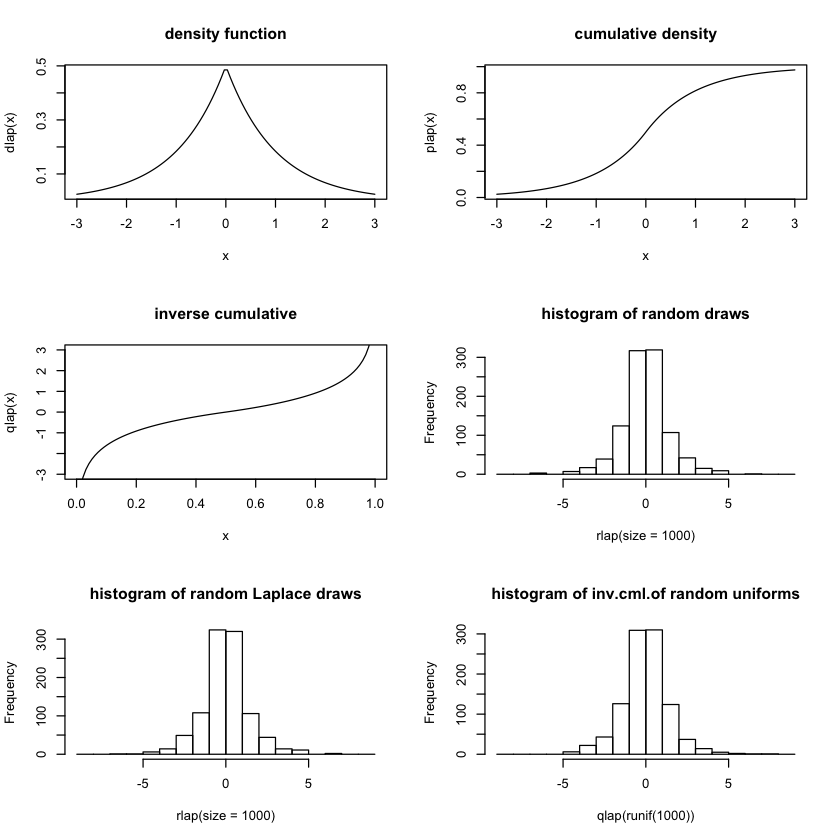

In [8]:
par(mfrow=c(3,2))
set.seed(123)

x<-seq(from=-3,to=3,length=100)

plot(x,dlap(x),type="l",main="density function")
plot(x,plap(x),type="l",main="cumulative density")

x<-seq(from=.001,to=.999,length=100)
plot(x,qlap(x),type="l",ylim=c(-3,3),main="inverse cumulative")

hist(rlap(size=1000),main="histogram of random draws", breaks=-9:9)
hist(rlap(size=1000),main="histogram of random Laplace draws", breaks=-9:9)
hist(qlap(runif(1000)),main="histogram of inv.cml.of random uniforms", breaks=-9:9)

**We can read the data from the GitHub repo, in this case our familiar PUMS5 Fulton file, and extract some variables to perform DP releases on:

In [2]:
library("foreign")
PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/FultonPUMS5full.csv")   

data <- PUMSdata$educ    		# variable for means

data.x <- PUMSdata$educ			# x-variable for regression
data.y <- PUMSdata$income		# y-variable for regression

populationTrue <- mean(data)

**Now create the functions for the Laplace mechanism for the mean (and partially completed for regression):

In [4]:
## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}

## Differentially private mean release
meanRelease <- function(x, epsilon){
    n <- length(x)
    lower <- min(x)
    upper <- max(x)
    
    sensitivity <- (upper - lower)/n
    scale <- sensitivity / epsilon

    x.clipped <- clip(x, lower, upper)
    sensitiveValue <- mean(x.clipped)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue))
}

## Differentially private regression slope release
regressionRelease <- function(y, x, ylower, yupper, xlower, xupper, epsilon){
	x <- clip(x, xlower, xupper)
	y <- clip(y, ylower, yupper)

	n <- length(x)
	sens.Sxy <- 1  # Fix this
	sens.Sxx <- 1  # Fix this

	scale.Sxy <- sens.Sxy / (epsilon/2)
	scale.Sxx <- sens.Sxx / (epsilon/2)

	sensitiveValue <- sum((x - mean(x))*(y - mean(y))) / sum((x - mean(x))^2) 

	release.Sxy <-  1  # Fix this
	release.Sxx <-  1  # Fix this

	postprocess.beta <- release.Sxy/release.Sxx
	return(list(release=postprocess.beta, true=sensitiveValue))
}


**Here is the actual simulation.  Note most of these lines are simply storing the simulation products:

In [5]:
n.sims <- 10												# number of simulations to run

my.seq <- seq(from=log10(200), to=log10(1500), length=20)  	# make evenly spaced in logarithmic space
n.seq  <- round(10^my.seq)                                 	# round to integers

my.seq <- seq(from=log10(1), to=log10(0.01), length=5)     	# make evenly spaced in logarithmic space
ep.seq <- round(10^my.seq * 100) /100						# round to two decimal places

rawhistory <- matrix(NA, nrow=length(n.seq)*length(ep.seq)*n.sims, ncol=4)  # matrix to store results
agghistory <- matrix(NA, nrow=length(n.seq)*length(ep.seq), ncol=3)         # matrix to store results
rawcount <- 0												# counter															
aggcount <- 0                                               # counter

for(i in 1:length(n.seq)){
	for(j in 1:length(ep.seq)){
		error <- NULL
		aggcount <- aggcount + 1
		for(k in 1:n.sims){
			rawcount <- rawcount + 1

			## Mean release
			bootdata <- bootstrap(x=data, n=n.seq[i])
			DPmean <- meanRelease(x=bootdata, epsilon=ep.seq[j])
			release <- DPmean$release
			sampleTrue <- DPmean$true

			## Regression release
			#bootdata <- bootstrap(x=data.x, y=data.y, n=n.seq[i])
			#DPregression <- regressionRelease(x=bootdata$x, y=bootdata$y, xlower=, xupper=, ylower=, yupper=, epsilon=ep.seq[j])
			#release <- DPregression$release
			#sampleTrue <- DPregression$true

			error <- c(error, sampleTrue - release)

			rawhistory[rawcount, 1] <- n.seq[i]
			rawhistory[rawcount, 2] <- ep.seq[j]
			rawhistory[rawcount, 3] <- release
			rawhistory[rawcount, 4] <- sampleTrue

		}
		agghistory[aggcount, 1] <- n.seq[i]
		agghistory[aggcount, 2] <- ep.seq[j]
		agghistory[aggcount, 3] <- sqrt( mean( (error)^2 ) )  # RMSE
	}
}


**The graphs are reasonably automated.  Graphs are learned by modifying examples, so see how we are extracting pieces from the larger result matrix:

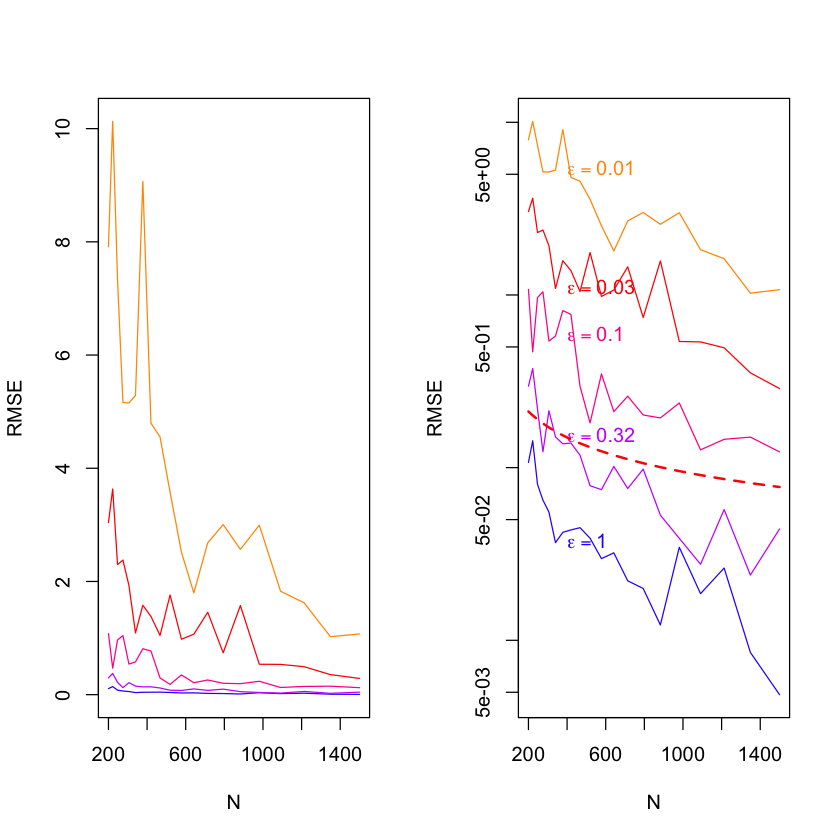

In [6]:
## Graphs for plotting results

par(mfcol=c(1,2))
color.palette<-rainbow(length(ep.seq), start=.7, end=.1)   # This creates a sequence of colors to use in subsequent plots, as in showchisq.r


for(j in 1:length(ep.seq)){
	flag <- agghistory[,2] == ep.seq[j]
	subhistory <- agghistory[flag,]

	allylim <- c(0, max(agghistory[,3]))

	if(j==1){
		plot(subhistory[,1],subhistory[,3], ylim=allylim, type="l", col=color.palette[j], xlab="N", ylab="RMSE")
	}else{
		lines(subhistory[,1],subhistory[,3], col=color.palette[j])
	}
}

for(j in 1:length(ep.seq)){
	flag <- agghistory[,2] == ep.seq[j]
	subhistory <- agghistory[flag,]

	allylim <- c(min(agghistory[,3]), max(agghistory[,3]))

	xloc <- round(length(n.seq)*0.3)

	if(j==1){
		plot(subhistory[,1],subhistory[,3], ylim=allylim, type="l", log = "y", col=color.palette[j], xlab="N", ylab="RMSE")
		text(x=subhistory[xloc,1], y=subhistory[xloc,3], label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4)
	}else{
		lines(subhistory[,1],subhistory[,3], col=color.palette[j])
		text(x=subhistory[xloc,1], y=subhistory[xloc,3], label=  bquote(paste(epsilon == .(ep.seq[j]))), col=color.palette[j], pos=4) 
	}

}

## Overlay the standard error of the mean
#se <- sd(PUMSdata$educ)/sqrt(n.seq)
#lines(n.seq, se, col="red", lty=2, lwd=2)



Call:
lm(formula = income ~ educ, data = PUMSdata)

Residuals:
   Min     1Q Median     3Q    Max 
-88281 -27621 -12621   8145 667453 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -38156       1323  -28.85   <2e-16 ***
educ            7308        120   60.90   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 57590 on 25764 degrees of freedom
Multiple R-squared:  0.1258,	Adjusted R-squared:  0.1258 
F-statistic:  3709 on 1 and 25764 DF,  p-value: < 2.2e-16



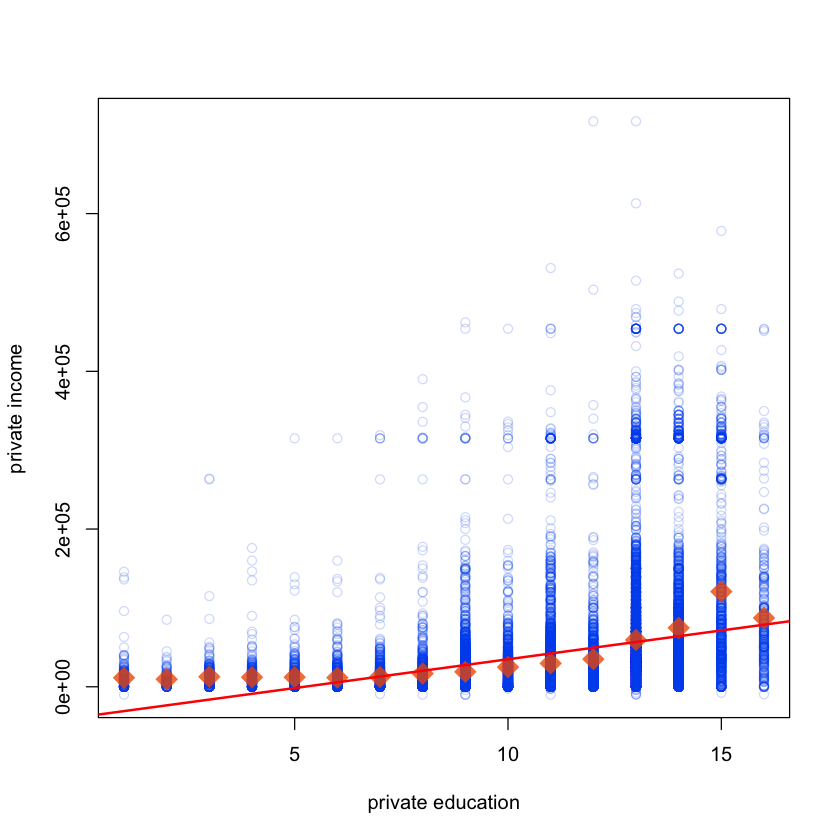

In [6]:
semi.blue <- rgb(0,90,239,50,maxColorValue=255)          # Slightly transparent colors
semi.red  <- rgb(239,90,0,200,maxColorValue=255)

plot(data.x, data.y, col=semi.blue, xlab="private education", ylab="private income")
educ.seq <- 1:16
for(i in 1:length(educ.seq)){
	flag <- data.x==educ.seq[i]
	partial.mean <- mean(data.y[flag])
	points(x=educ.seq[i], y=partial.mean, col=semi.red, pch=18, cex=2.5)
}
output <- lm(income ~ educ, data=PUMSdata)
abline(a=coef(output)[1], b=coef(output)[2], lwd=2, col="red")
print(summary(output))